In [1]:
import csv
import ast
import math
import pickle
import random
import numpy as np
import copy
from collections import Counter
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
meta_data = pickle.load(open("Dataset\\metadata",'rb'))
Keyword = pickle.load(open("Dataset\\Keyword",'rb'))
train_dict, test_dict = pickle.load(open("Dataset\\train_and_test_dict",'rb'))
user_ratings = pickle.load(open("Dataset\\user_ratings_dict",'rb'))

In [4]:
movie_ids = []
for user in user_ratings.keys():
    movie_ids += list(user_ratings[user].keys())

In [5]:
movie_ids = set(movie_ids)
len(movie_ids)

4320

<h3> Generate movie-features dictionary </h3>

In [6]:
def get_movies_with_keytems(keyword_doc, movies):
    for row in keyword_doc:
        movie_id = int(row[0])
        if movies.get(movie_id) is None:
            continue
        keyterms = list()
        movie_keyterm_dic_list = ast.literal_eval(row[1])
        for movie_keyterm_dic in movie_keyterm_dic_list:
            keyterms.append(movie_keyterm_dic['name'])
        movies[movie_id]["keyterms"] = keyterms
    return movies

In [7]:
def get_movie_with_actors_directors(movies):
    with open("Dataset\\credits.csv", 'r', errors = 'ignore') as csvfile:
        spamreader = csv.DictReader(csvfile)
        for row in spamreader:
            movie_id = int(row['id'])
            if movies.get(movie_id) is None:
                continue
            actors = list()
            cast = ast.literal_eval(row["cast"])
            for actor in cast:
                actors.append(actor['name'].replace(" ", "").lower())
            movies[movie_id]["actors"] = actors    
            crew = ast.literal_eval(row["crew"])
            directors = list()
            for member in crew:
                if member['job'].lower() == "director":
                    directors.insert(0, member['name'].replace(" ", "").lower())
                elif 'director' in member['job'].lower():
                    name = member['name'].replace(" ", "").lower()
                    directors.append(name)
            movies[movie_id]["directors"] = directors    
    return movies

In [8]:
def get_movie_genre_countr_descr(movies, meta_data):
    for row in meta_data:
        if not row['id'].isdecimal():
            continue
        else:
            movie_id = int(row['id'])
        if movies.get(movie_id) is None:
            continue
        if row.get("overview") is not None:
            movies[movie_id]["overview"] = row.get("overview")
        else:
            movies[movie_id]["overview"] = []
        genres = list()
        gs = ast.literal_eval(row["genres"])
        for genre in gs:
            genres.append(genre['name'].replace(" ", "").lower())
        movies[movie_id]["genres"] = genres
        
        countries = list()
        cs = ast.literal_eval(row["production_countries"])
        for country in cs:
            countries.append(country['name'].replace(" ", "").lower())
        movies[movie_id]["countries"] = countries
    return movies

In [9]:
def get_movie_dic_with_details(meta_data, Keyword):
    movies = dict()
    for movie_id in movie_ids:
        movies[movie_id] = dict()
    movies_with_keyterms = get_movies_with_keytems(Keyword, movies)
    movies_with_keyterms_actors_directors = get_movie_with_actors_directors(movies_with_keyterms)
    movies_with_details_dic = get_movie_genre_countr_descr(movies_with_keyterms_actors_directors, meta_data)
    return movies_with_details_dic

<h3>Functions to generate movie docs for generating tf-idf vecctors</h3>

In [10]:
def get_f2_doc(movie_data, f2_features):
    g2 = f2_features
    l2 = []
    mapping = []
    for i in movie_data.keys():
        mapping.append(i)
        movie = movie_data[i]        
        temp_doc = ''
        for j in range(len(g2)):
            if g2[j] == 'overview':
                if len(temp_doc) == 0:
                    temp_doc += movie[g2[j]]
                else:
                    temp_doc += ' ' + movie[g2[j]]
            else:
                for lm in range(len(movie[g2[j]])):
                    if len(temp_doc) == 0:
                        temp_doc += movie[g2[j]][lm]
                    else:
                        temp_doc += ' ' + movie[g2[j]][lm]
        l2.append(temp_doc)
    return l2, mapping

In [11]:
def get_f1_doc(movie_data, mapping, f1_features, a):
    g1 = f1_features
    l1 = []
    for i in mapping:
        movie = movie_data[i]
        temp_doc = ''
        for j in range(len(g1)):
            if g1[j] == 'actors':
                for k in range(a):
                    try:
                        if len(temp_doc) == 0:
                            temp_doc += movie[g1[j]][k]
                        else:
                            temp_doc += ' ' + movie[g1[j]][k]
                    except:
                        break
            elif g1[j] == 'overview':
                if len(temp_doc) == 0:
                    temp_doc += movie[g1[j]]
                else:
                    temp_doc += ' ' + movie[g1[j]]
            else:
                for lm in range(len(movie[g1[j]])):
                    if len(temp_doc) == 0:
                        temp_doc += movie[g1[j]][lm]
                    else:
                        temp_doc += ' ' + movie[g1[j]][lm]
        l1.append(temp_doc)
    return l1

<h3>Generate tf-idf vectors and similarity matrix from movie docs</h3>

In [12]:
def get_tf_idf_vecs_from_docs(doc_data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(doc_data)
    Y = X.toarray()
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(Y)
    tf_idf_vecs = tfidf.toarray()
    return tf_idf_vecs

In [13]:
def get_sim_matr(tf_idf_vecs):
    sim_matr = cosine_similarity(tf_idf_vecs, tf_idf_vecs)
    smoothing_val = np.unique(sim_matr)[1]
    sim_matr += smoothing_val
    sim_matr = sim_matr / np.max(sim_matr, axis=1)
    return sim_matr

<h3>Train, Test and Plot functions</h3>

In [14]:
def user_pred_errors(user_ratings, ratio, sim_matr_1, sim_matr_2, mapping):
    movie_ids = list(user_ratings.keys())
    np.random.shuffle(movie_ids)
    train_pts = len(movie_ids) - int(0.2 * len(movie_ids))
    
    train_ratings = np.array([user_ratings[mid] for mid in movie_ids[:train_pts]])
    train_ind = [mapping.index(mid) for mid in movie_ids[:train_pts]]
    
    test_ratings = np.array([user_ratings[mid] for mid in movie_ids[train_pts:]])
    test_ind = [mapping.index(mid) for mid in movie_ids[train_pts:]]
    
    user_mean = np.mean(train_ratings)
    errors = []
    for i in range(len(test_ratings)):
        pred = 0
        sim_sum = 0
        for j in range(len(train_ratings)):
            sim_val = ((sim_matr_1[test_ind[i]][train_ind[j]] * ratio) + (sim_matr_2[test_ind[i]][train_ind[j]] * (1-ratio)))
            pred += sim_val * (train_ratings[j] - user_mean)
            sim_sum += sim_val
        pred = pred / sim_sum
        pred = pred + user_mean
        error = (pred - test_ratings[i])**2
        errors.append(error)
    return errors

In [15]:
def training(train_user_dict, sim_matr_1, sim_matr_2, mapping, start, incr): 
    a = []
    rmse = []
    print("Tested for alpha: ", end='')
    for alpha in np.arange(start, 1.01, incr):
        alpha = round(alpha,2)
        error = []
        for j in train_user_dict.keys():
            error += user_pred_errors(train_user_dict[j], alpha, sim_matr_1, sim_matr_2, mapping)
        error = np.array(error)
        mean_all = np.mean(error)
        sv = mean_all ** 0.5
        rmse.append(sv)
        a.append(alpha)
        print(alpha, end=' ')
    print()
    return a, rmse 

In [16]:
def testing(test_user_dict, sim_matr_1, sim_matr_2, mapping, alpha): 
    error = []
    for j in test_user_dict.keys():
        error += user_pred_errors(test_user_dict[j], alpha, sim_matr_1, sim_matr_2, mapping)
    error = np.array(error)
    mean_all = np.mean(error)
    rmse = mean_all ** 0.5
    return rmse

In [17]:
def get_plot(x, y, axis_names=['x-axis','y-axis'], title = ''):
    plt.figure(figsize=(12,5))
    plt.plot(x, y) 
    plt.xlabel(axis_names[0])
    plt.ylabel(axis_names[1])
    xi = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    plt.xticks(xi)
    plt.title(title,fontweight='bold')
    plt.grid()
    plt.show()

In [18]:
def f1_train_test(f1_sim_matr, f2_sim_matr, mapping, train_dict, test_dict):
    alphas, rmse_list = training(train_dict, f1_sim_matr, f2_sim_matr, mapping, 0, 0.05)
    
    get_plot(alphas, rmse_list, axis_names=['Alpha (ratio)','RMSE'], title = 'RMSE plot for different parameter(alpha) values')
    min_ind = rmse_list.index(min(rmse_list[1:]))
    best_alpha = alphas[min_ind]
    train_rmse = round(rmse_list[min_ind], 4)
    
    test_rmse = round(testing(test_dict, f1_sim_matr, f2_sim_matr, mapping, best_alpha), 4)    
    print("Results:-  Alpha: ", best_alpha,"   Train RMSE: ", train_rmse, "   Test RMSE: ", test_rmse)
    return test_rmse, train_rmse, best_alpha

<h3> Feature selection</h3>

In [19]:
def f1_wrapper_feature_selection(movie_data, f1_features, f2_sim_matr, mapping, train_dict, test_dict):
    remaining = copy.deepcopy(f1_features)
    selected = []
    iter_no = 0
    train_rmse_list, test_rmse_list, alpha_list, f1_dimen_list, feature_combinations = [], [], [], [], []
    while remaining:
        scores = []
        for feature in remaining:
            iter_no += 1
            new_f1_features = selected + [feature]
            print("F1 feature combination : ",new_f1_features)
            
            f1_docs = get_f1_doc(movie_data, mapping, new_f1_features, 10)
            f1_tf_idf_vecs = get_tf_idf_vecs_from_docs(f1_docs)
            f1_sim_matr = get_sim_matr(f1_tf_idf_vecs)
            with open("Vector_spaces\\f1_"+ str(iter_no) +"_tf_idf_vecs", 'wb') as vsp:
                pickle.dump(f1_tf_idf_vecs, vsp)
            
            test_rmse, train_rmse, alpha = f1_train_test(f1_sim_matr, f2_sim_matr, mapping, train_dict, test_dict)
            scores.append(test_rmse)
            train_rmse_list.append(train_rmse)
            alpha_list.append(alpha)
            f1_dimen_list.append(f1_tf_idf_vecs.shape[1])
            feature_combinations.append(new_f1_features)
            print('-------------------------------------------------------------------------------------\n')
            
        test_rmse_list += scores
        min_ind = scores.index(min(scores))
        selected.append(remaining.pop(min_ind))
    return train_rmse_list, test_rmse_list, alpha_list, f1_dimen_list, feature_combinations

<h3>Execute phase 1</h3>

In [20]:
movies_with_details_dic = get_movie_dic_with_details(meta_data, Keyword)
# movies_with_details_dic = pickle.load(open("Dataset\\movies_with_details_dic",'rb'))

In [21]:
with open("Dataset\\movies_with_details_dic", 'wb') as fp:
    pickle.dump(movies_with_details_dic, fp)

In [22]:
f1_features = ['actors','directors','keyterms','genres', 'countries']
f2_features = ['overview']

In [23]:
f2_docs, mapping = get_f2_doc(movies_with_details_dic, f2_features)
f2_tf_idf_vecs = get_tf_idf_vecs_from_docs(f2_docs)
f2_sim_matr = get_sim_matr(f2_tf_idf_vecs)
with open("Vector_spaces\\f2_tf_idf_vecs", 'wb') as vsp:
    pickle.dump(f2_tf_idf_vecs, vsp)
with open("Vector_spaces\\mapping", 'wb') as vsp:
    pickle.dump(mapping, vsp)

F1 feature combination :  ['actors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


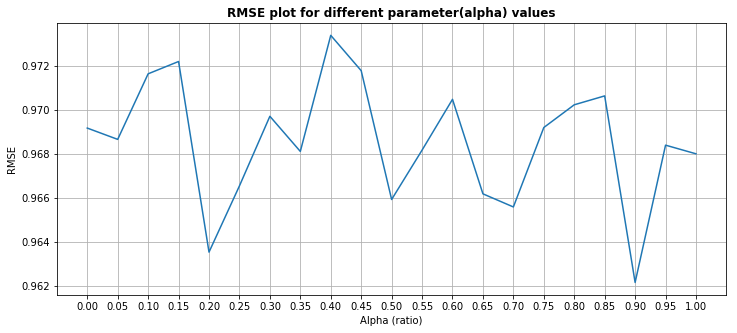

Results:-  Alpha:  0.9    Train RMSE:  0.9622    Test RMSE:  0.9531
-------------------------------------------------------------------------------------

F1 feature combination :  ['directors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


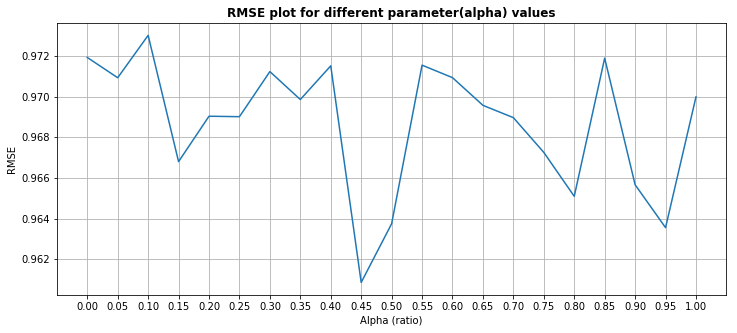

Results:-  Alpha:  0.45    Train RMSE:  0.9609    Test RMSE:  0.9342
-------------------------------------------------------------------------------------

F1 feature combination :  ['keyterms']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


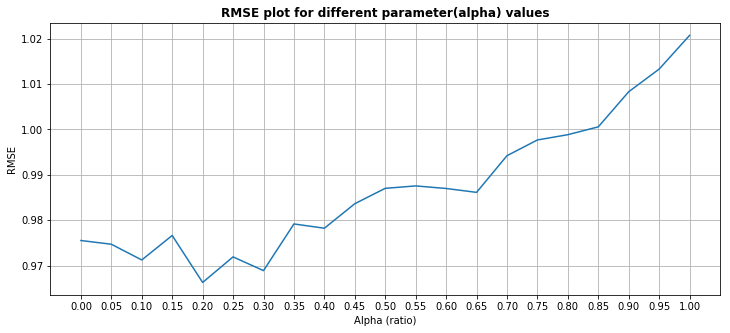

Results:-  Alpha:  0.2    Train RMSE:  0.9663    Test RMSE:  0.9542
-------------------------------------------------------------------------------------

F1 feature combination :  ['genres']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


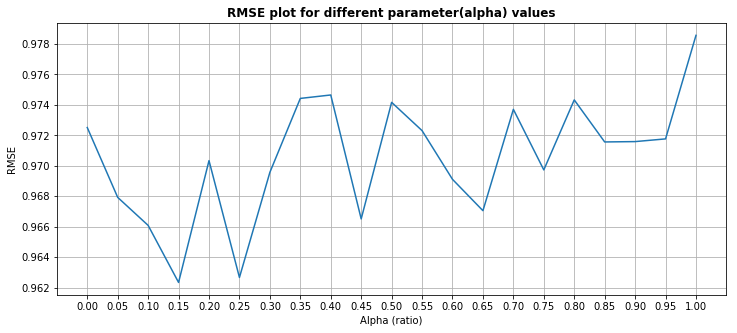

Results:-  Alpha:  0.15    Train RMSE:  0.9623    Test RMSE:  0.9408
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


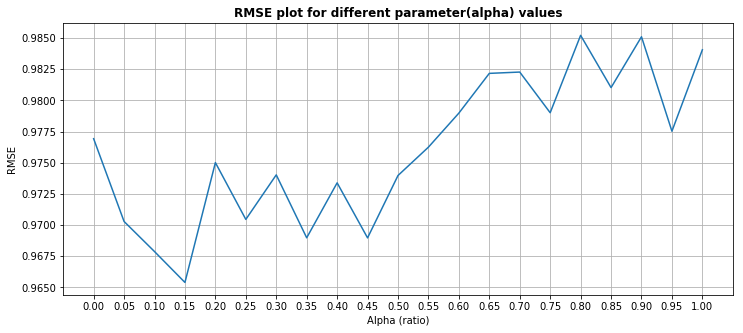

Results:-  Alpha:  0.15    Train RMSE:  0.9654    Test RMSE:  0.9307
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'actors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


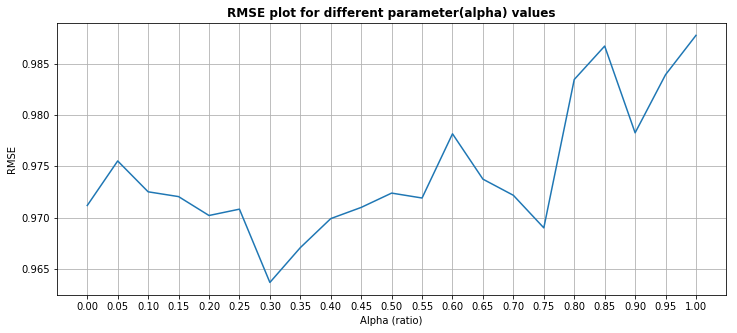

Results:-  Alpha:  0.3    Train RMSE:  0.9637    Test RMSE:  0.9486
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'directors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


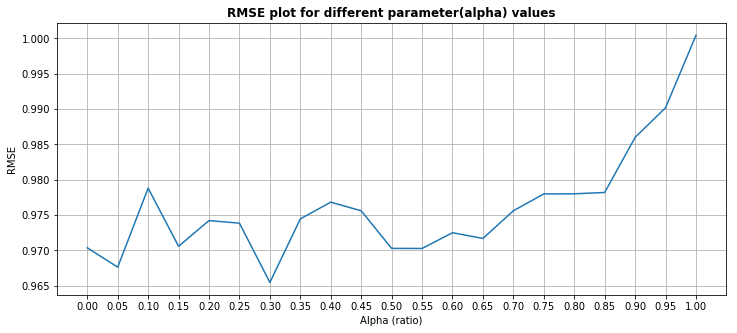

Results:-  Alpha:  0.3    Train RMSE:  0.9655    Test RMSE:  0.9501
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'keyterms']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


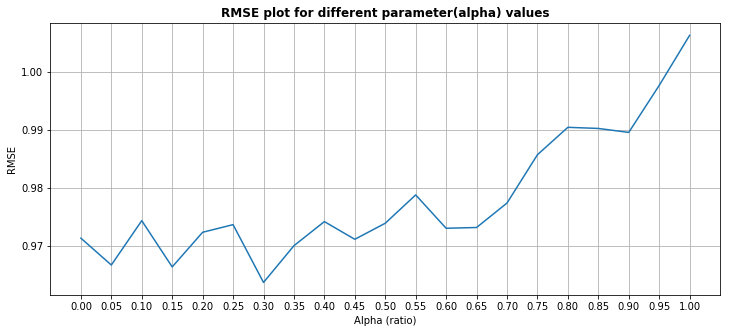

Results:-  Alpha:  0.3    Train RMSE:  0.9636    Test RMSE:  0.9529
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


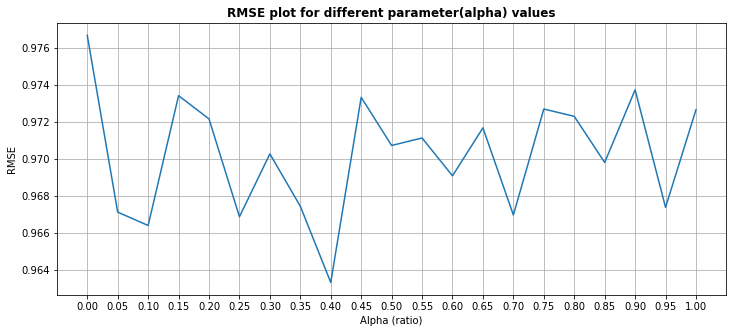

Results:-  Alpha:  0.4    Train RMSE:  0.9633    Test RMSE:  0.9346
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres', 'actors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


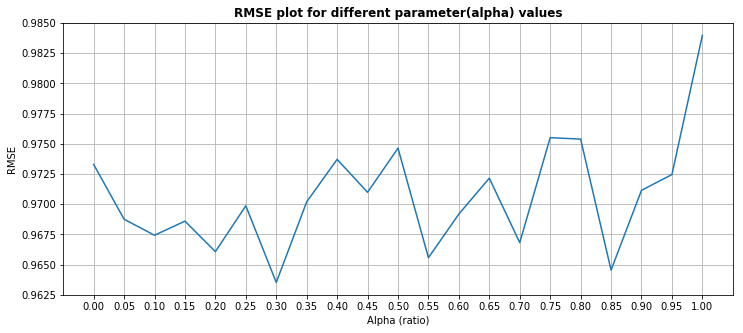

Results:-  Alpha:  0.3    Train RMSE:  0.9635    Test RMSE:  0.9437
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres', 'directors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


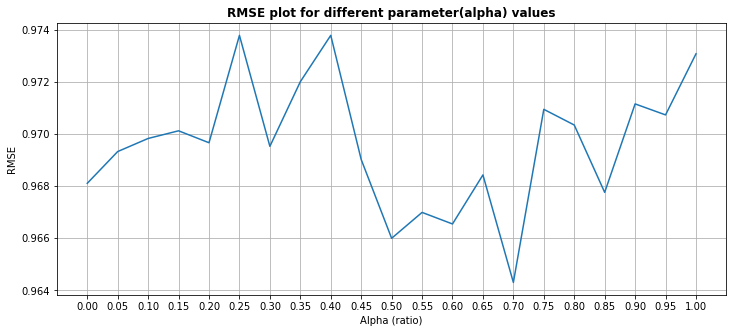

Results:-  Alpha:  0.7    Train RMSE:  0.9643    Test RMSE:  0.9536
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres', 'keyterms']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


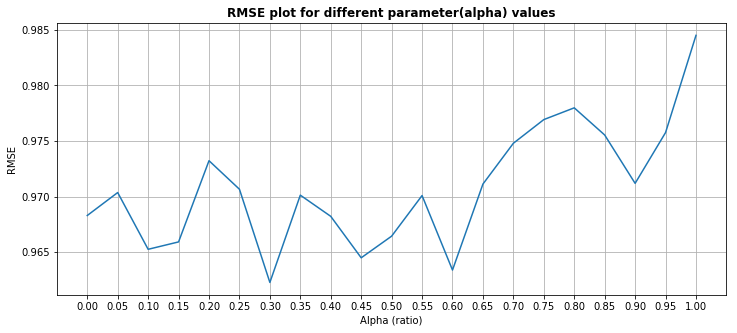

Results:-  Alpha:  0.3    Train RMSE:  0.9623    Test RMSE:  0.9542
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres', 'actors', 'directors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


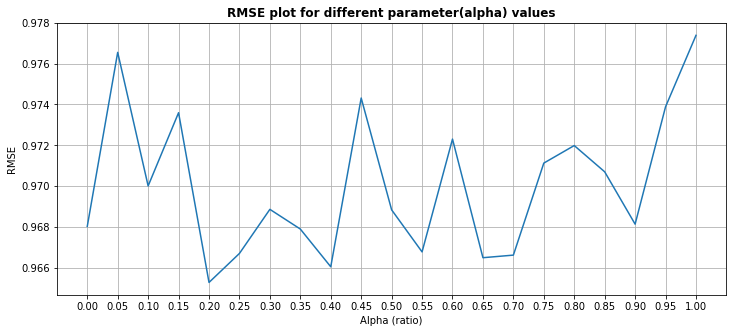

Results:-  Alpha:  0.2    Train RMSE:  0.9653    Test RMSE:  0.94
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres', 'actors', 'keyterms']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


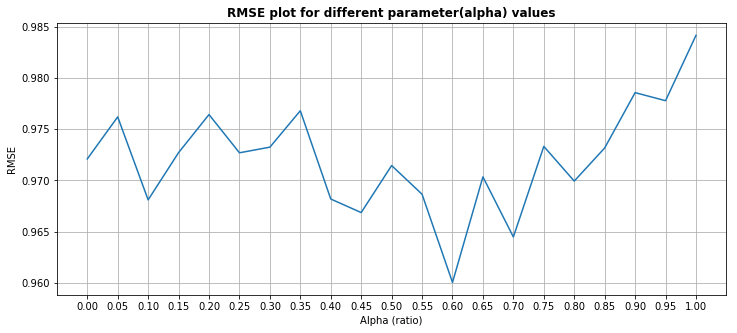

Results:-  Alpha:  0.6    Train RMSE:  0.9601    Test RMSE:  0.9384
-------------------------------------------------------------------------------------

F1 feature combination :  ['countries', 'genres', 'actors', 'keyterms', 'directors']
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


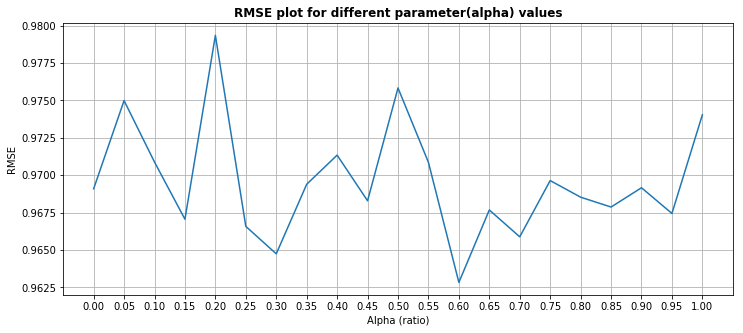

Results:-  Alpha:  0.6    Train RMSE:  0.9628    Test RMSE:  0.9476
-------------------------------------------------------------------------------------



In [24]:
train_rmse_list, test_rmse_list, alpha_list, f1_dimen_list, feature_combinations = f1_wrapper_feature_selection(movies_with_details_dic, 
                                                                                                                    f1_features, 
                                                                                                                    f2_sim_matr, 
                                                                                                                    mapping, 
                                                                                                                    train_dict, 
                                                                                                                    test_dict)

In [25]:
x = PrettyTable()
x.field_names = ["Index", "F1 Features", "F1 dim", "F2 dim", "alpha", "Train RMSE", "Test RMSE"]
i = -1
# print(feature_combinations)
for f_com in feature_combinations:
    i += 1
    t = f_com[0]
    for f in f_com[1:]:
        t = t + ', ' + f
    x.add_row([str(i), t, f1_dimen_list[i], f2_tf_idf_vecs.shape[1], alpha_list[i], train_rmse_list[i], test_rmse_list[i]])
print(x)

+-------+------------------------------------------------+--------+--------+-------+------------+-----------+
| Index |                  F1 Features                   | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+------------------------------------------------+--------+--------+-------+------------+-----------+
|   0   |                     actors                     | 23627  | 22180  |  0.9  |   0.9622   |   0.9531  |
|   1   |                   directors                    |  6031  | 22180  |  0.45 |   0.9609   |   0.9342  |
|   2   |                    keyterms                    |  6392  | 22180  |  0.2  |   0.9663   |   0.9542  |
|   3   |                     genres                     |   20   | 22180  |  0.15 |   0.9623   |   0.9408  |
|   4   |                   countries                    |   97   | 22180  |  0.15 |   0.9654   |   0.9307  |
|   5   |               countries, actors                | 23724  | 22180  |  0.3  |   0.9637   |   0.9486  |
|   6   | 

In [26]:
with open("feature_combinations", 'wb') as bpt:
        pickle.dump(feature_combinations, bpt)